### Importing Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get data
To build a time series forecasting model, the first thing we're going to need is data.

And since we're trying to predict the price of Bitcoin, we'll need Bitcoin data.

We're going to get the prices of Bitcoin from `17 September 2014` to `10 August 2022`.

`17 September 2014` specifically because is was when yahoo finance started recording the price of Bitcoin and `10 August 2022` is when this notebook was created.


In [28]:
import yfinance as yf

In [29]:
Bit = yf.Ticker("BTC-USD")

In [30]:
df = Bit.history(period = 'max')
df = df.drop(columns = ['Dividends' , 'Stock Splits'] , axis = 1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [31]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-08,23179.527344,24203.689453,23176.546875,23809.486328,28575544847
2022-08-09,23811.484375,23898.615234,22982.000000,23164.318359,23555719219
2022-08-10,23162.898438,24127.414062,22771.519531,23947.642578,32837431722
2022-08-11,23948.345703,24822.628906,23900.996094,23957.529297,37127036580
2022-08-12,23966.562500,24078.126953,23828.593750,23892.189453,32256534528


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2887 entries, 2014-09-17 to 2022-08-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2887 non-null   float64
 1   High    2887 non-null   float64
 2   Low     2887 non-null   float64
 3   Close   2887 non-null   float64
 4   Volume  2887 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 135.3 KB


In [33]:
# How many samples do we have?
len(df)

2887

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2885 total samples.

|1 sample per timeframe |Number of samples per year
|:-----------------:	|:-----------------:|
|Second	                |31,536,000|
|Hour	                |8,760|
|Day	                |365|
|Week	                |52|
|Month	                |12|

🔑 Note: The frequency at which a time series value is collected is often referred to as seasonality. This is usually measured in number of samples per year


### Types of Time Series
|Trend  |Time series has a clear long-term increase or decrease (may or may not be linear)
|:----: |:-----------------:|
|Seasonal | Time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
|Cyclic | Time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

<AxesSubplot:xlabel='Date'>

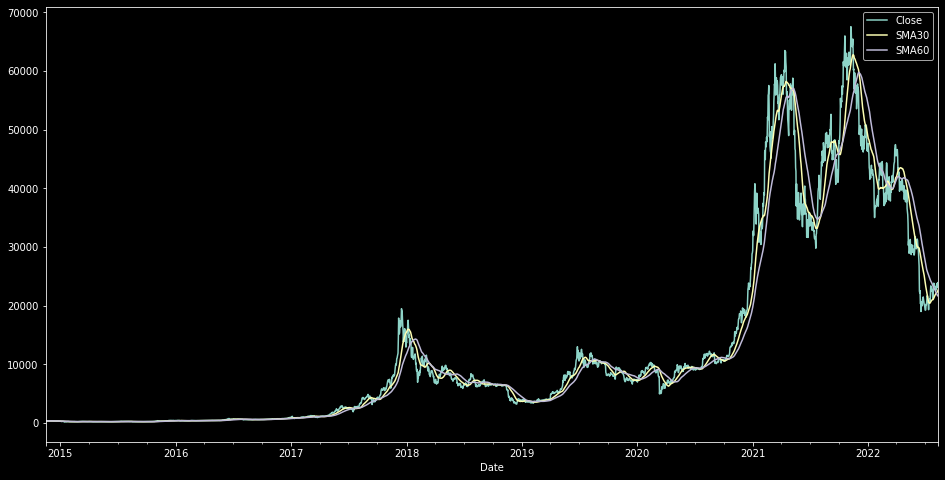

In [34]:
df['SMA30'] = df['Close'].rolling(30).mean()
df['SMA60'] = df['Close'].rolling(60).mean()

df.dropna(inplace = True)

df[['Close' , 'SMA30', 'SMA60']].plot(label = 'Bitcoin', figsize = (16 , 8))

In [35]:
# Only want closing prices for each day 
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns = {'Close': "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-15,376.132996
2014-11-16,387.881989
2014-11-17,387.407990
2014-11-18,375.197998
2014-11-19,380.554993


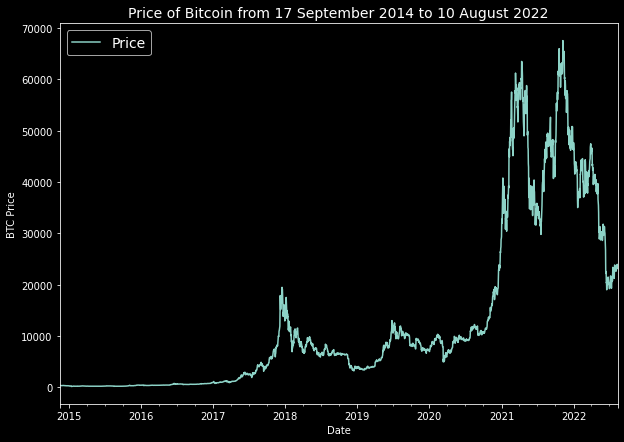

In [36]:
bitcoin_prices.plot(figsize = (10 , 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 17 September 2014 to 10 August 2022" , fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

<AxesSubplot:xlabel='Date'>

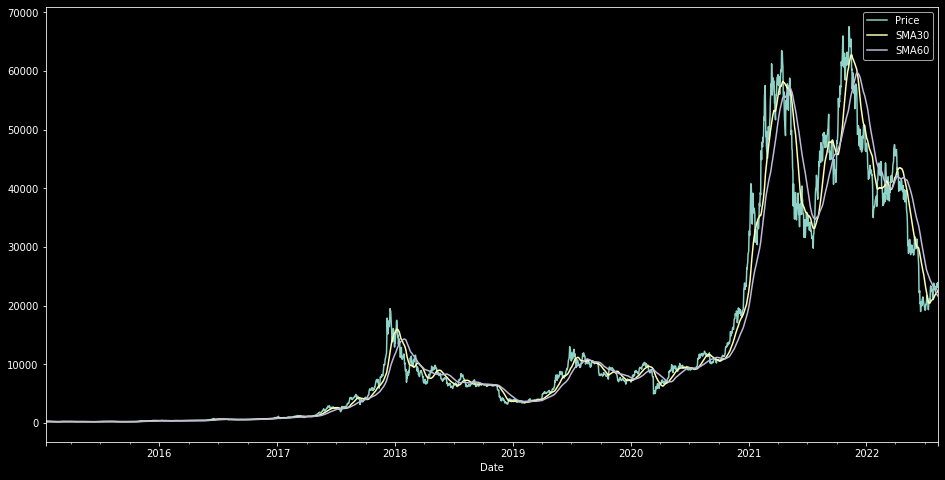

In [37]:
bitcoin_prices['SMA30'] = bitcoin_prices['Price'].rolling(30).mean()
bitcoin_prices['SMA60'] = bitcoin_prices['Price'].rolling(60).mean()

bitcoin_prices.dropna(inplace = True)

bitcoin_prices[['Price' , 'SMA30', 'SMA60']].plot(label = 'Bitcoin', figsize = (16 , 8))

In [38]:
# Only want closing prices for each day 
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns = {'Close': "Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-15,376.132996
2014-11-16,387.881989
2014-11-17,387.407990
2014-11-18,375.197998
2014-11-19,380.554993


### Create train & test sets for time series

In [39]:
# get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

In [40]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices))

# Create train data splits (everything before the split)
X_train , y_train = timesteps[:split_size] , prices[:split_size]

# Create test data splits (everything after the split)
X_test , y_test = timesteps[split_size:] , prices[split_size:]

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(2262, 566, 2262, 566)

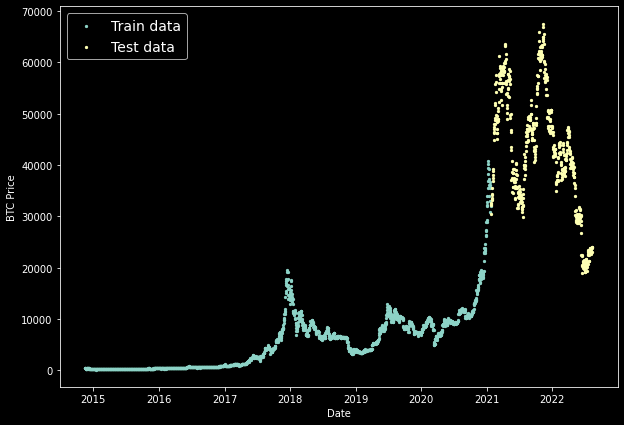

In [41]:
plt.figure(figsize = (10 , 7))
plt.scatter(X_train , y_train , s = 5 , label = "Train data")
plt.scatter(X_test , y_test , s = 5 , label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize = 14)
plt.show()

### Create a plotting function

In [42]:
# Create a function to plot time series data
def plot_time_series(timesteps , values , format =".", start = 0, end = None, label = None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
    
    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    
    # Plot the series
    plt.plot(timesteps[start:end] , values[start:end], format , label = label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)    

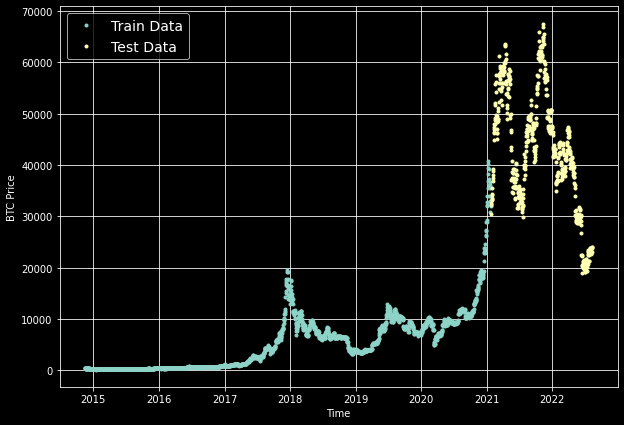

In [43]:
# Try out our plotting function
plt.figure(figsize = (10 , 7))
plot_time_series(timesteps = X_train , values = y_train , label = "Train Data")
plot_time_series(timesteps = X_test , values = y_test , label = "Test Data")

### Experiments we're running 
Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

|Experiment |  Model | Horizon Size | Window Size 
|:--------: | :-----:|:-----------:|:-----------: 
|0          | Naive model (baseline)| NA| NA
|1          | Dense model |1 | 7
|2          | Same as model 1| 1 | 30
|3          | Same as model 1| 1 | 30 
|4          | Conv1D| 1 | 7
|5          | LSTM| 1 | 7
|6          | Same as model 1 (but with multivariate data)| 1 | 7
|7          | N-BEATS algorithm| 1 | 7
|8          | Ensemble (multiple models stacked together)| 1 | 7
|9          | Future prediction model| 1 | 7
|10         | Same as model 1 (but with turkey data introduced)| 1 | 7

### Model 0: Naive forecast (baseline)

The formula looks like this:
$$\hat{y}_t = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for horizon of 1.

In [44]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10] , naive_forecast[-10:]

(array([32289.37890625, 32366.39257812, 32569.84960938, 30432.546875  ,
        33466.09765625, 34316.38671875, 34269.5234375 , 33114.359375  ,
        33537.17578125, 35510.2890625 ]),
 array([22978.1171875 , 22846.5078125 , 22630.95703125, 23289.31445312,
        22961.27929688, 23175.890625  , 23809.48632812, 23164.31835938,
        23947.64257812, 23957.52929688]))

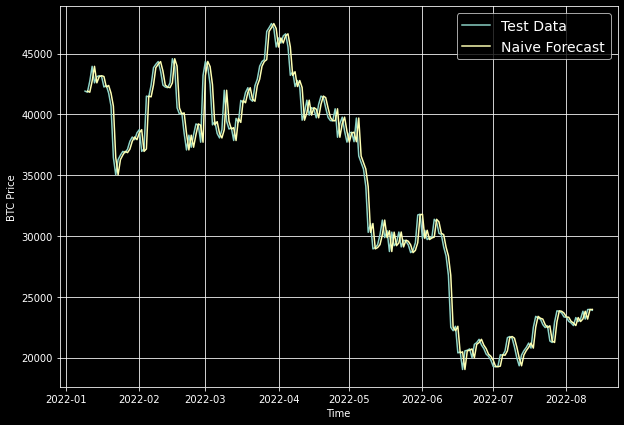

In [45]:
# Plot naive forecast 
plt.figure(figsize = (10 , 7))
# plot_time_series(timesteps = X_train , values = y_train , label = "Train Data")
plot_time_series(timesteps = X_test , values = y_test , start = 350 , format = "-" , label = "Test Data")
plot_time_series(timesteps = X_test[1:] , values = naive_forecast , start = 350 , format = "-" , label = "Naive Forecast")

### Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

> 📖 Resource: We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in <a href = "https://otexts.com/fpp3/accuracy.html">Forecasting: Principles and Practice chapter 5.8</a>. I'd recommend reading through here for a more in-depth overview of what we're going to practice.

### Scale-dependent errors
These are metrics which can be used to compare time series values and forecasts that are on the same scale.

|Metric         | Details       | Code
|:----:         |:------:       |:----:
|MAE (mean absolute error)| Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median.	| tf.keras.metrics.mean_absolute_error()
|RMSE (root mean square error)| Forecasts which minimise the RMSE lead to forecasts of the mean.| tf.sqrt(tf.keras.metrics.mean_square_error())

### Percentage errors
Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.
|Metric         | Details       | Code
|:----:         |:------:       |:----:
|MAPE (mean absolute percentage error)| Most commonly used percentage error. May explode (not work) if y=0.| tf.keras.metrics.mean_absolute_percentage_error()
|sMAPE (symmetric mean absolute percentage error)| Recommended not to be used by `Forecasting:Principals and Practice`, though it is used in forecasting competitions.| Custom implementation


### Scaled errors
Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.
|Metric         | Details       | Code
|:----:         |:------:       |:----:
|MASE (mean absolute scaled error)| MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE.|<a href="https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16">See sktime's mase_loss()</a>

In [46]:
import tensorflow as tf

In [47]:
# MASE implementation
def mean_absolute_scaled_error(y_true , y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Find MAE of naive forecast (no seasonality)
    mae_native_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    
    return mae / mae_native_no_season

In [48]:
mean_absolute_scaled_error(y_true = y_test[1:] , y_pred = naive_forecast).numpy()

0.9983445786752275

In [49]:
def evaluate_preds (y_true , y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true , dtype = tf.float32)
    y_pred = tf.cast(y_pred , dtype = tf.float32)
    
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true , y_pred)
    
    
    return {'mae': mae.numpy(),
            'mse': mse.numpy(),
            'rmse': rmse.numpy(),
            'mape': mape.numpy(),
            'mase': mase.numpy()}

In [50]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forecast)
naive_results

{'mae': 1188.5886,
 'mse': 2765042.2,
 'rmse': 1662.8417,
 'mape': 2.8268242,
 'mase': 0.99834454}

#### Other kinds of time series forecasting models which can be used for baselines and actual forecasts

|Model/Library Name| Resource
|:----------------:|:--------:
|Moving Average| <https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/>
|ARIMA (Autoregression Integrated Moving Average| <https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/>
|sktime (Scikit-Learn for time series| <https://github.com/alan-turing-institute/sktime>
|TensorFlow Decision Forests (random forest, gradient boosting trees| <https://www.tensorflow.org/decision_forests>
|Facebook Kats (purpose-built forecasting and time series analysis library by Facebook| <https://github.com/facebookresearch/Kats>
|Linkedln Greykite (flexible intuitive and fast forecasts| <https://github.com/linkedin/greykite>


### Format Data Part2: Windowing our dataset
We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0 , 1 , 2 , 3 , 4 , 5 , 6] -> [7]
[1 , 2 , 3 , 4 , 5 , 6 , 7] -> [8]
[2 , 3 , 4 , 5 , 6 , 7 , 8] -> [9]

In [51]:
# What we want to do with out Bitcoin data
print(f"We want to use: {prices[:7]} to predict this: {prices[7]}")

We want to use: [376.13299561 387.88198853 387.4079895  375.19799805 380.55499268
 357.83999634 350.84799194] to predict this: 352.9200134277344


In [52]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [53]:
# Create function to label windowed data
def get_labelled_windows (x , horizon = HORIZON):
    '''
    Creates labels for windowed dataset.
    E.g. if horizon = 1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    '''
    return x[:, :-horizon] , x[:, -horizon: ]

In [54]:
# Test out the window labelling function
test_window , test_label = get_labelled_windows(tf.expand_dims(tf.range(8) , axis = 0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical prices of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into window with a specified horizon.

> 📖 Resource: The function created below has been adapted from Syafiq Kamarul Azman's article <a href = "https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5">Fast and Robust Sliding Window Vectorization with NumPy.</a>

In [55]:
# Create function to view Numpy arrays as windows
def make_windows(x , window_size = WINDOW_SIZE , horizon = HORIZON):
    '''
    Turns a 1D array into a 2D array of sequential windows of window_size (add the horizon on the end for later labelling)
    '''
    # 1. Create a window of specific window_size (add the horizon)
    window_step = np.expand_dims(np.arange(window_size + horizon) , axis = 0)
    
    # 2. Create a 2D array of multiple window steps (minus 1 for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)) , axis = 0).T # Create a 2D array of window of size window_size
    
    # print(f"Window indexes:\n {window_indexes , window_indexes.shape}")
    
    # 3. Index on the target array (a time series) with 2D array of multiple window steps
    window_array = x[window_indexes]
    # print(window_array)
    
    # 4. Get the labelled windows
    windows , labels = get_labelled_windows(window_array , horizon = horizon)
    return windows , labels

In [56]:
full_windows , full_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
len(full_windows) , len(full_labels)

(2821, 2821)

In [57]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label {full_labels[i]}")

Window: [376.13299561 387.88198853 387.4079895  375.19799805 380.55499268
 357.83999634 350.84799194] -> Label [352.92001343]
Window: [387.88198853 387.4079895  375.19799805 380.55499268 357.83999634
 350.84799194 352.92001343] -> Label [367.57299805]
Window: [387.4079895  375.19799805 380.55499268 357.83999634 350.84799194
 352.92001343 367.57299805] -> Label [376.90100098]


**Note**: There's a function which does similar to the above in tf.keras.preprocessing and extension could be to try and replicate what we've done using the premade function.
<https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array>

### Turning windows into training and test sets

In [58]:
# Make the train/test splits
def make_train_test_splits(windows , labels , test_split = 0.2):
    '''
    Splits matching pairs of windows and labels into train and test splits.
    '''
    splits_size = int(len(windows) * (1 - test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [59]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

(2262, 559, 2262, 559)

### Making a model checkpoint

In [60]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [61]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
18/18 [==============================] - 5s 125ms/step - loss: 1327.8931 - mae: 1327.8931 - val_loss: 5424.6821 - val_mae: 5424.6821
Epoch 2/100
18/18 [==============================] - 1s 48ms/step - loss: 396.3329 - mae: 396.3329 - val_loss: 2332.5505 - val_mae: 2332.5505
Epoch 3/100
18/18 [==============================] - 1s 39ms/step - loss: 289.9384 - mae: 289.9384 - val_loss: 2099.4827 - val_mae: 2099.4827
Epoch 4/100
18/18 [==============================] - 1s 45ms/step - loss: 266.1315 - mae: 266.1315 - val_loss: 1909.0492 - val_mae: 1909.0492
Epoch 5/100
18/18 [==============================] - 1s 42ms/step - loss: 259.2188 - mae: 259.2188 - val_loss: 1867.9536 - val_mae: 1867.9536
Epoch 6/100
18/18 [==============================] - 1s 49ms/step - loss: 249.4249 - mae: 249.4249 - val_loss: 1777.5894 - val_mae: 1777.5894
Epoch 7/100
18/18 [==============================] - 0s 3ms/step - loss: 242.9281 - mae: 242.9281 - val_loss: 1789.9022 - val_mae: 1789.9022
Epoc

In [62]:
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1227.9481 - mae: 1227.9481


[1227.9481201171875, 1227.9481201171875]

In [63]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1202.2909 - mae: 1202.2909


[1202.2908935546875, 1202.2908935546875]

### Making forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset (note: these won;t be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:
1. Take in a train model
2. Takes in sime input data (same kind of data the model was trained on)
3. Passes the input data to the model's predict() method
4. Returns the prediction

In [64]:
def make_preds (model , input_data):
    '''
    Uses model to make predictions input_data.
    '''
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [65]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1 , test_windows)
len(model_1_preds) , model_1_preds[:10]

(559,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([34453.766, 33262.266, 33588.312, 35314.242, 37295.008, 37150.164,
        38063.508, 39304.21 , 39228.586, 45111.46 ], dtype=float32)>)

In [66]:
test_labels.shape

(559, 1)

In [67]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 1202.2908,
 'mse': 2808114.2,
 'rmse': 1675.7429,
 'mape': 2.865633,
 'mase': 1.0102842}

In [68]:
naive_results

{'mae': 1188.5886,
 'mse': 2765042.2,
 'rmse': 1662.8417,
 'mape': 2.8268242,
 'mase': 0.99834454}

### Plotting our predictions

In [69]:
test_labels[: , 0].shape

(559,)

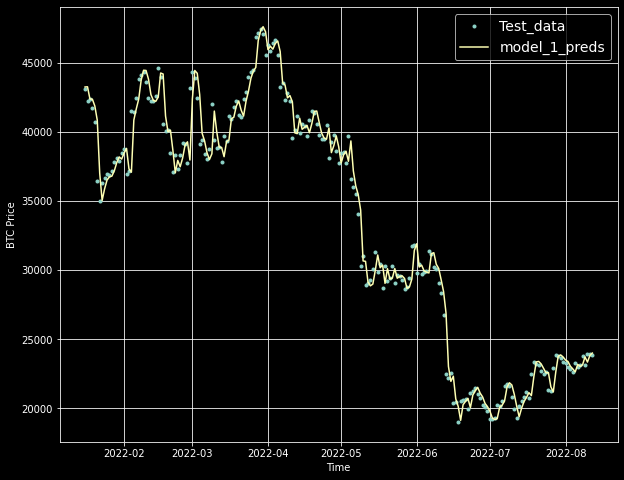

In [73]:
offset = 350
plt.figure(figsize=(10, 8))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30 , horizon = 1)

In [117]:
HORIZON = 1
WINDOW_SIZE = 30

In [118]:
full_windows , full_labels = make_windows(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
len(full_windows) , len(full_labels)

(2798, 2798)

In [119]:
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels, test_split = 0.2)
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels) 

(2262, 536, 2262, 536)

In [120]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(HORIZON , activation = 'linear')
], name = 'model_2_dense')

model_2.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae'])

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [121]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows , test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1560.2893 - mae: 1560.2893


[1560.289306640625, 1560.289306640625]

In [122]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows , test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 1291.4395 - mae: 1291.4395


[1291.439453125, 1291.439453125]

In [123]:
# Get forecast predictions
model_2_preds = make_preds(model_2, input_data = test_windows)

In [124]:
tf.squeeze(test_labels).shape , model_2_preds.shape

(TensorShape([536]), TensorShape([536]))

In [125]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 1291.4393,
 'mse': 3081773.8,
 'rmse': 1755.4982,
 'mape': 3.1044152,
 'mase': 1.1110284}

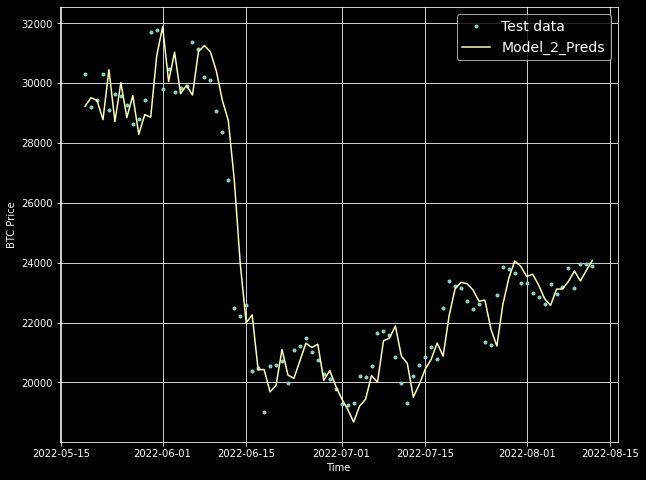

In [126]:
offset = 450
plt.figure(figsize = (10 , 8))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[: , 0] , start = offset , format = '.', label = "Test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_2_preds , start = offset , format = '-' , label = 'Model_2_Preds')

### Model 3: Dense (window = 30 , horizon = 7)

In [127]:
HORIZON = 7
WINDOW_SIZE = 30

In [128]:
full_windows , full_labels = make_windows(prices, window_size = WINDOW_SIZE , horizon = HORIZON)
len(full_windows) , len(full_labels)

(2792, 2792)

In [129]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows,
                                                                                labels = full_labels)
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

(2262, 530, 2262, 530)

In [130]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(128 , activation = 'relu'),
    layers.Dense(HORIZON , activation = 'linear')
], name = 'model_3_Dense')

# Compile model
model_3.compile(loss = 'MAE',
                optimizer = tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_Dense\assets
INFO:tensorflow:Assets written to: mod

In [131]:
# Evaluate the model on the test data
model_3.evaluate(test_windows , test_labels)

17/17 [==============================] - 0s 10ms/step - loss: 2602.2673


2602.267333984375

In [135]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_Dense/")
model_3.evaluate(test_windows , test_labels)

17/17 [==============================] - 0s 1ms/step - loss: 2506.3499


2506.349853515625

In [136]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data = test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[56054.32 , 55302.742, 55888.03 , 54386.875, 53996.137, 54757.273,
        54543.12 ],
       [51673.38 , 50905.17 , 52079.098, 50698.4  , 50623.297, 51126.406,
        51185.895],
       [50635.875, 49206.844, 50324.895, 48864.547, 49120.64 , 49072.414,
        49214.504],
       [48334.21 , 46501.582, 46670.047, 45678.543, 46608.28 , 46323.9  ,
        44018.375],
       [46841.21 , 45301.02 , 46457.67 , 45373.688, 46477.277, 45568.234,
        43623.7  ]], dtype=float32)>

In [137]:
# Evaluate model_3 results 
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': array([ 7429.6665 ,  3688.0352 ,  2400.013  ,  2617.1997 ,  2764.6262 ,
         4722.322  ,  6359.522  ,  3740.2825 ,  4012.8762 ,  3940.7583 ,
         4516.042  ,  6032.5894 ,  6446.118  ,  5329.938  ,  5515.6064 ,
         4103.5024 ,  2598.352  ,  1514.4135 ,  1511.6641 ,  2834.2673 ,
         3775.7617 ,  1613.4119 ,  2498.4988 ,  3026.3599 ,  4252.1914 ,
         4580.2993 ,  4104.2505 ,  3319.263  ,  2058.0317 ,  3067.7683 ,
         5040.6377 ,  6526.52   ,  5866.0195 ,  3900.0317 ,  3437.3381 ,
         2450.351  ,  2028.2784 ,  1097.2584 ,  1232.2897 ,  1320.9889 ,
          970.9235 ,  1104.3967 ,  1003.0173 ,  1540.5212 ,  3354.2188 ,
         3954.0403 ,  4227.0874 ,  2919.8286 ,  3275.6997 ,  3274.6223 ,
         3224.8528 ,  4268.632  ,  6672.1714 ,  7452.5786 ,  7837.015  ,
         4886.9727 ,  3817.5217 ,  3016.1858 ,  2165.2495 ,  2391.5535 ,
         3777.3833 ,  5814.725  ,  7992.9126 ,  4879.856  ,  3434.8655 ,
         2587.3137 ,  3270.629  ,  1723.9642

### Make our evaluation function work for larger horizons

In [140]:
model_2_results['mae'].ndim, model_3_results['mae'].ndim

(0, 1)

In [141]:
tf.reduce_mean(model_3_results['mae']).numpy(), model_3.evaluate(test_windows , test_labels)

17/17 [==============================] - 0s 2ms/step - loss: 2506.3499


(2506.3499, 2506.349853515625)

In [142]:
def evaluate_preds (y_true , y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true , dtype = tf.float32)
    y_pred = tf.cast(y_pred , dtype = tf.float32)
    
    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true , y_pred)
    
    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)    
        mse = tf.reduce_mean(mse)    
        rmse = tf.reduce_mean(rmse)    
        mape = tf.reduce_mean(mape)    
        mase = tf.reduce_mean(mase)    
    
    return {'mae': mae.numpy(),
            'mse': mse.numpy(),
            'rmse': rmse.numpy(),
            'mape': mape.numpy(),
            'mase': mase.numpy()}

In [143]:
# Get model_3 results aggregated to single value
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': 2506.3499,
 'mse': 11330595.0,
 'rmse': 2863.9314,
 'mape': 6.011974,
 'mase': 2.149517}

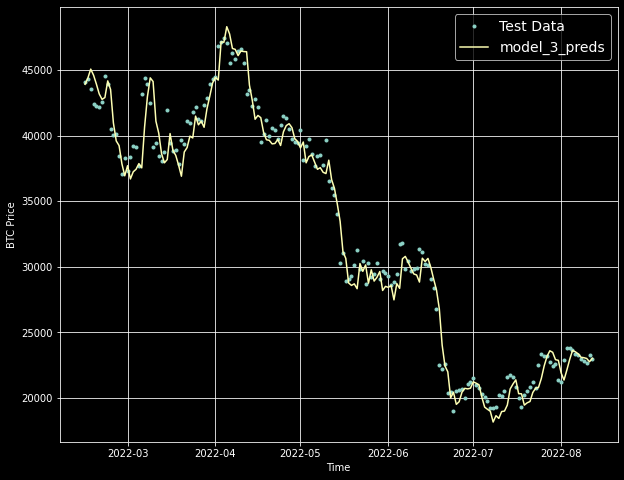

In [154]:
offset = 350
plt.figure(figsize = (10 , 8))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[: , 0], start = offset, label = "Test Data")
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = tf.reduce_mean(model_3_preds, axis = 1),
                 start = offset,
                 format = '-',
                 label = 'model_3_preds')


### Which of our models is performing best so far?

<AxesSubplot:>

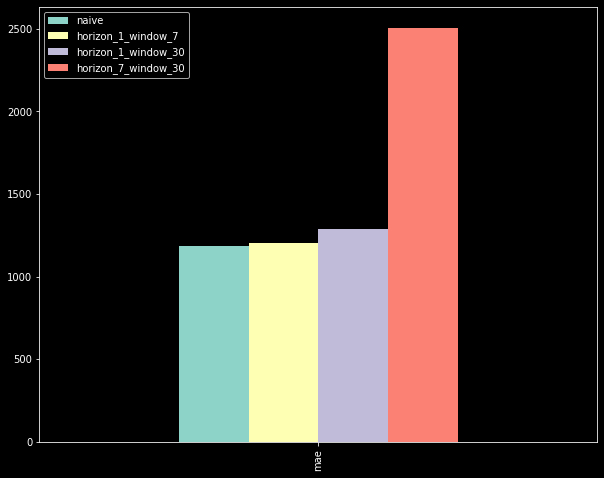

In [165]:
pd.DataFrame({'naive': naive_results['mae'],
              'horizon_1_window_7': model_1_results['mae'],
              "horizon_1_window_30": model_2_results['mae'],
              "horizon_7_window_30": model_3_results['mae']}, index = ['mae']).plot(figsize = (10 , 8), kind = 'bar')

> **Note:** You might be wondering why are the naive results so good? One of the reasons could be due to the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t + 1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, naive model will often get fairly good results.

📖 Resource: For more on how autocorrelation influences a model's predictions, see the article 
<a href = "https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424">How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls</a> by Vegard Flovik

### Model 4: Conv1D

In [166]:
HORIZON = 1
WINDOW_SIZE = 7

In [167]:
# Create windowed data
full_windows , full_labels = make_windows(prices , window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows) , len(full_labels)

(2821, 2821)

In [169]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows , full_labels, test_split = 0.2)
len(train_windows) , len(train_labels), len(test_windows) , len(test_labels)

(2262, 2262, 559, 559)

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

In our case, the batch_size (by default this is 32 but we can change it) is handled for us but the other values will be:

* timesteps = WINDOW_SIZE - the timesteps is also often referred to as features, our features are the previous WINDOW_SIZE values of Bitcoin
* input_dim = HORIZON - our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [172]:
train_windows[0].shape

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a `tf.keras.layers.Lamdba` (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [174]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f'Original values with expanded shape:\n {expand_dims_layer(x)}')

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[376.133]
 [387.882]
 [387.408]
 [375.198]
 [380.555]
 [357.84 ]
 [350.848]]


In [177]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x , axis = 1)),
    layers.Conv1D(filters = 128, kernel_size = WINDOW_SIZE , strides = 1, padding = 'causal', activation = 'relu'), # Padding is 'causal' since our data is temporal.
    layers.Dense(HORIZON)
], name = 'model_4_conv1D')

# Compile model
model_4.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size = 128,
            epochs = 100,
            verbose = 1,
            validation_data = [test_windows, test_labels],
            callbacks = [create_model_checkpoint(model_name = model_4.name)])

Epoch 1/100
18/18 [==============================] - 2s 94ms/step - loss: 2540.2273 - val_loss: 3431.2991
Epoch 2/100
18/18 [==============================] - 1s 66ms/step - loss: 542.3078 - val_loss: 3042.2295
Epoch 3/100
18/18 [==============================] - 1s 77ms/step - loss: 360.1572 - val_loss: 2295.0728
Epoch 4/100
18/18 [==============================] - 1s 88ms/step - loss: 328.1285 - val_loss: 2274.7317
Epoch 5/100
18/18 [==============================] - 3s 178ms/step - loss: 318.9454 - val_loss: 2210.9678
Epoch 6/100
18/18 [==============================] - 4s 259ms/step - loss: 310.7822 - val_loss: 2181.3743
Epoch 7/100
18/18 [==============================] - 3s 158ms/step - loss: 307.2186 - val_loss: 2154.9978
Epoch 8/100
18/18 [==============================] - 2s 145ms/step - loss: 299.8241 - val_loss: 2123.3884
Epoch 9/100
18/18 [==============================] - 2s 121ms/step - loss: 295.8428 - val_loss: 2113.7661
Epoch 10/100
18/18 [=============================

In [178]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            6400      
                                                                 
 dense_11 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [179]:
# Evaluate model
model_4.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1220.1443


1220.144287109375

In [180]:
# Load back in best performing Conv1D and re-evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1220.1443


1220.144287109375

In [181]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([34200.492, 33406.645, 33471.883, 35121.46 , 37041.883, 37076.098,
       37942.086, 39201.816, 39061.457, 44652.56 ], dtype=float32)>

In [182]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 1220.1443,
 'mse': 2836139.2,
 'rmse': 1684.0841,
 'mape': 2.901338,
 'mase': 1.0252866}

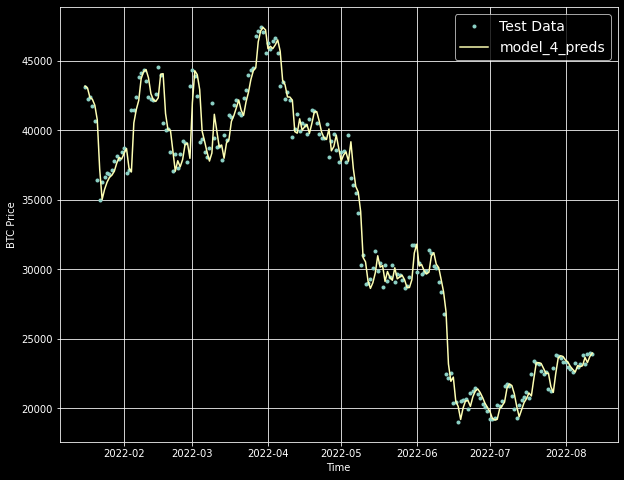

In [204]:
offset = 350
plt.figure(figsize = (10 , 8))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[: , 0], start = offset , label = 'Test Data')
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_4_preds , start = offset , format = '-' , label = 'model_4_preds')

### Model 5: RNN (LSTM)

In [218]:
HORIZON = 1
WINDOW_SIZE = 7

In [219]:
tf.random.set_seed(42)

# Let's build an LSTM model with the functional API
inputs = layers.Input(shape = (WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(inputs)
x = layers.LSTM(128 , return_sequences = True, activation = 'relu')(x)
x = layers.LSTM(64 , activation = 'relu')(x)
x = layers.Dense(32 , activation = 'relu')(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs = inputs , outputs = output , name = 'model_5_LSTM')

# Compile model
model_5.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
history_5 = model_5.fit(train_windows,
                        train_labels,
                        epochs = 100,
                        validation_data = (test_windows, test_labels),
                        verbose = 1,
                        batch_size = 128,
                        callbacks = [create_model_checkpoint(model_name = model_5.name)]
                        )

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 5184.8330INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 11s 297ms/step - loss: 5184.8330 - val_loss: 36969.9805
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 3794.1611INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 7s 386ms/step - loss: 3653.8264 - val_loss: 13069.3232
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 729.8507INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 287ms/step - loss: 729.8507 - val_loss: 3302.7490
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 396.2003INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 278ms/step - loss: 382.0568 - val_loss: 2065.1772
Epoch 5/100
14/18 [======================>.......] - ETA: 0s - loss: 302.6209INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 10s 557ms/step - loss: 299.7659 - val_loss: 1995.3054
Epoch 6/100
18/18 [==============================] - 0s 13ms/step - loss: 275.9232 - val_loss: 2027.5197
Epoch 7/100
18/18 [==============================] - 0s 13ms/step - loss: 281.0495 - val_loss: 2022.7495
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 270.0987INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 318ms/step - loss: 275.8738 - val_loss: 1972.9067
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 275.7755INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 255ms/step - loss: 274.3792 - val_loss: 1967.4081
Epoch 10/100
18/18 [==============================] - 0s 17ms/step - loss: 272.6094 - val_loss: 2461.9348
Epoch 11/100
18/18 [==============================] - 0s 25ms/step - loss: 291.2032 - val_loss: 1988.4989
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 273.4946INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 288ms/step - loss: 272.7920 - val_loss: 1893.2306
Epoch 13/100
18/18 [==============================] - 0s 14ms/step - loss: 255.1420 - val_loss: 2070.4180
Epoch 14/100
18/18 [==============================] - 0s 19ms/step - loss: 264.9248 - val_loss: 2016.8287
Epoch 15/100
18/18 [==============================] - 0s 14ms/step - loss: 265.9389 - val_loss: 2127.4084
Epoch 16/100
15/18 [========================>.....] - ETA: 0s - loss: 262.2152INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 260ms/step - loss: 257.9430 - val_loss: 1868.8900
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 264.4408INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 354ms/step - loss: 258.5524 - val_loss: 1839.7386
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 247.7704INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 283ms/step - loss: 247.0421 - val_loss: 1710.4905
Epoch 19/100
18/18 [==============================] - 1s 23ms/step - loss: 250.6368 - val_loss: 1905.7480
Epoch 20/100
18/18 [==============================] - 0s 17ms/step - loss: 259.8304 - val_loss: 1833.3951
Epoch 21/100
18/18 [==============================] - 0s 24ms/step - loss: 246.4257 - val_loss: 1752.7561
Epoch 22/100
18/18 [==============================] - 0s 14ms/step - loss: 244.3885 - val_loss: 1721.6124
Epoch 23/100
18/18 [==============================] - 0s 14ms/step - loss: 244.8493 - val_loss: 1717.4762
Epoch 24/100
18/18 [==============================] - 0s 22ms/step - loss: 249.1782 - val_loss: 1761.7136
Epoch 25/100
18/18 [==============================] - 0s 17ms/step - loss: 237.4841 - val_loss: 1726.7664
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 232.3964INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 346ms/step - loss: 229.7621 - val_loss: 1681.3300
Epoch 27/100
18/18 [==============================] - 1s 20ms/step - loss: 228.3054 - val_loss: 1739.5983
Epoch 28/100
18/18 [==============================] - 0s 15ms/step - loss: 229.1606 - val_loss: 1869.1667
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 234.0993INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 15s 878ms/step - loss: 226.9640 - val_loss: 1619.7046
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 219.8517INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 247ms/step - loss: 219.8517 - val_loss: 1603.9901
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 216.0225INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 7s 388ms/step - loss: 216.0225 - val_loss: 1588.8384
Epoch 32/100
18/18 [==============================] - 2s 32ms/step - loss: 212.8100 - val_loss: 1697.8043
Epoch 33/100
18/18 [==============================] - 0s 16ms/step - loss: 218.8319 - val_loss: 1650.8796
Epoch 34/100
18/18 [==============================] - ETA: 0s - loss: 209.2929INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 14s 838ms/step - loss: 209.2929 - val_loss: 1576.9801
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 222.3262INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 323ms/step - loss: 222.0064 - val_loss: 1499.8616
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 202.8373INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 8s 446ms/step - loss: 205.4471 - val_loss: 1492.9995
Epoch 37/100
18/18 [==============================] - ETA: 0s - loss: 200.7125INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 307ms/step - loss: 200.7125 - val_loss: 1478.3650
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 201.2158INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 239ms/step - loss: 201.2158 - val_loss: 1450.3663
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 203.4687INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 257ms/step - loss: 207.0935 - val_loss: 1432.4758
Epoch 40/100
18/18 [==============================] - ETA: 0s - loss: 192.2216INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 255ms/step - loss: 192.2216 - val_loss: 1415.5555
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 195.6160INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 280ms/step - loss: 195.8459 - val_loss: 1409.2543
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 192.5656INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 261ms/step - loss: 192.5656 - val_loss: 1392.0326
Epoch 43/100
18/18 [==============================] - 0s 18ms/step - loss: 190.6743 - val_loss: 1405.8650
Epoch 44/100
17/18 [===========================>..] - ETA: 0s - loss: 190.1756INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 243ms/step - loss: 189.1957 - val_loss: 1364.1390
Epoch 45/100
18/18 [==============================] - 0s 16ms/step - loss: 188.2779 - val_loss: 1379.0409
Epoch 46/100
18/18 [==============================] - 0s 15ms/step - loss: 190.9307 - val_loss: 1508.5992
Epoch 47/100
18/18 [==============================] - 0s 16ms/step - loss: 198.7153 - val_loss: 1367.7203
Epoch 48/100
15/18 [========================>.....] - ETA: 0s - loss: 183.6012INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 260ms/step - loss: 185.3314 - val_loss: 1352.6765
Epoch 49/100
18/18 [==============================] - 0s 17ms/step - loss: 182.1750 - val_loss: 1511.7275
Epoch 50/100
18/18 [==============================] - 0s 16ms/step - loss: 190.3619 - val_loss: 1484.1354
Epoch 51/100
18/18 [==============================] - 0s 16ms/step - loss: 184.1964 - val_loss: 1415.8953
Epoch 52/100
17/18 [===========================>..] - ETA: 0s - loss: 185.5497INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 245ms/step - loss: 182.6279 - val_loss: 1321.8876
Epoch 53/100
18/18 [==============================] - 1s 28ms/step - loss: 178.2505 - val_loss: 1379.7494
Epoch 54/100
18/18 [==============================] - 0s 20ms/step - loss: 193.7241 - val_loss: 1353.9746
Epoch 55/100
18/18 [==============================] - 0s 17ms/step - loss: 185.6084 - val_loss: 1521.9722
Epoch 56/100
18/18 [==============================] - 0s 19ms/step - loss: 186.3706 - val_loss: 1343.3141
Epoch 57/100
18/18 [==============================] - 0s 16ms/step - loss: 187.9670 - val_loss: 1598.0526
Epoch 58/100
18/18 [==============================] - 0s 17ms/step - loss: 183.3060 - val_loss: 1344.4261
Epoch 59/100
18/18 [==============================] - 0s 19ms/step - loss: 185.8601 - val_loss: 1417.7306
Epoch 60/100
18/18 [==============================] - ETA: 0s - loss: 183.6272INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 325ms/step - loss: 183.6272 - val_loss: 1299.8445
Epoch 61/100
18/18 [==============================] - 0s 16ms/step - loss: 183.4702 - val_loss: 1376.7108
Epoch 62/100
18/18 [==============================] - ETA: 0s - loss: 186.6511INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 6s 365ms/step - loss: 186.6511 - val_loss: 1294.2927
Epoch 63/100
18/18 [==============================] - 0s 15ms/step - loss: 176.8984 - val_loss: 1318.5781
Epoch 64/100
18/18 [==============================] - 0s 21ms/step - loss: 176.7902 - val_loss: 1327.9561
Epoch 65/100
18/18 [==============================] - 0s 18ms/step - loss: 182.9525 - val_loss: 1317.6899
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 182.0104INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 250ms/step - loss: 179.5097 - val_loss: 1286.3971
Epoch 67/100
18/18 [==============================] - 0s 17ms/step - loss: 179.2700 - val_loss: 1313.1985
Epoch 68/100
18/18 [==============================] - 0s 16ms/step - loss: 179.5101 - val_loss: 1420.3445
Epoch 69/100
18/18 [==============================] - 0s 16ms/step - loss: 194.0878 - val_loss: 1533.4163
Epoch 70/100
17/18 [===========================>..] - ETA: 0s - loss: 177.9733INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 237ms/step - loss: 177.5745 - val_loss: 1278.1855
Epoch 71/100
18/18 [==============================] - 0s 17ms/step - loss: 177.4500 - val_loss: 1304.5978
Epoch 72/100
18/18 [==============================] - 0s 18ms/step - loss: 172.0637 - val_loss: 1278.6483
Epoch 73/100
18/18 [==============================] - 0s 18ms/step - loss: 179.1842 - val_loss: 1283.9440
Epoch 74/100
18/18 [==============================] - 0s 15ms/step - loss: 181.0456 - val_loss: 1299.0521
Epoch 75/100
17/18 [===========================>..] - ETA: 0s - loss: 176.0561INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 12s 689ms/step - loss: 176.0467 - val_loss: 1273.5287
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 175.9047INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 226ms/step - loss: 173.6212 - val_loss: 1263.1433
Epoch 77/100
18/18 [==============================] - 0s 16ms/step - loss: 170.8513 - val_loss: 1266.7742
Epoch 78/100
18/18 [==============================] - 0s 16ms/step - loss: 180.3775 - val_loss: 1271.0740
Epoch 79/100
18/18 [==============================] - 0s 16ms/step - loss: 175.3837 - val_loss: 1292.7554
Epoch 80/100
17/18 [===========================>..] - ETA: 0s - loss: 171.3663INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 234ms/step - loss: 171.4632 - val_loss: 1254.0574
Epoch 81/100
18/18 [==============================] - 0s 17ms/step - loss: 173.7056 - val_loss: 1315.0012
Epoch 82/100
18/18 [==============================] - 0s 17ms/step - loss: 177.0999 - val_loss: 1383.9525
Epoch 83/100
18/18 [==============================] - 0s 16ms/step - loss: 189.0871 - val_loss: 1362.0991
Epoch 84/100
18/18 [==============================] - 0s 16ms/step - loss: 173.4879 - val_loss: 1383.6704
Epoch 85/100
18/18 [==============================] - 0s 16ms/step - loss: 182.7816 - val_loss: 1443.9100
Epoch 86/100
18/18 [==============================] - 0s 17ms/step - loss: 188.6785 - val_loss: 1299.0206
Epoch 87/100
18/18 [==============================] - 0s 23ms/step - loss: 180.5715 - val_loss: 1390.7439
Epoch 88/100
16/18 [=========================>....] - ETA: 0s - loss: 170.7116INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 272ms/step - loss: 171.5926 - val_loss: 1253.1233
Epoch 89/100
18/18 [==============================] - 0s 18ms/step - loss: 176.4685 - val_loss: 1361.1498
Epoch 90/100
18/18 [==============================] - 0s 17ms/step - loss: 171.7917 - val_loss: 1302.6537
Epoch 91/100
18/18 [==============================] - 0s 17ms/step - loss: 181.6319 - val_loss: 1536.8318
Epoch 92/100
18/18 [==============================] - 0s 17ms/step - loss: 186.4593 - val_loss: 1269.3751
Epoch 93/100
18/18 [==============================] - 0s 16ms/step - loss: 170.3597 - val_loss: 1269.4858
Epoch 94/100
18/18 [==============================] - 0s 16ms/step - loss: 175.0735 - val_loss: 1404.2963
Epoch 95/100
16/18 [=========================>....] - ETA: 0s - loss: 170.9574INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 242ms/step - loss: 170.7133 - val_loss: 1233.2252
Epoch 96/100
17/18 [===========================>..] - ETA: 0s - loss: 167.6957INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 252ms/step - loss: 172.4598 - val_loss: 1232.8771
Epoch 97/100
18/18 [==============================] - 0s 18ms/step - loss: 174.5246 - val_loss: 1276.0145
Epoch 98/100
18/18 [==============================] - 0s 17ms/step - loss: 177.1250 - val_loss: 1304.0133
Epoch 99/100
18/18 [==============================] - 0s 18ms/step - loss: 175.0877 - val_loss: 1291.6073
Epoch 100/100
18/18 [==============================] - 0s 17ms/step - loss: 168.2002 - val_loss: 1340.6715


In [220]:
# Load in the best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows , test_labels)

18/18 [==============================] - 9s 10ms/step - loss: 1232.8772


1232.877197265625

In [221]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds.shape

TensorShape([559])

In [222]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 1232.877,
 'mse': 2892306.2,
 'rmse': 1700.6782,
 'mape': 2.941029,
 'mase': 1.0359858}

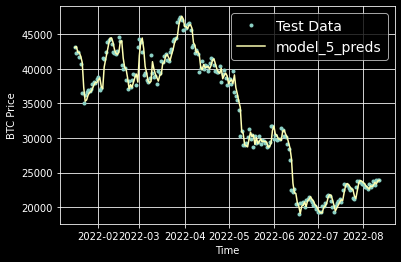

In [226]:
offset = 350 
plot_time_series(timesteps = X_test[-len(test_windows):] , values = test_labels[: , 0], start = offset , label = 'Test Data')
plot_time_series(timesteps = X_test[-len(test_windows):] , values = model_5_preds , start = offset , format = '-', label = 'model_5_preds')

### Make a mulitvariate time series dataset
Before we add a feature to our time series, what is a feature we can use?

How about the bitcoin halving events?
<https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving>

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

> 🔑 Note: Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [227]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2014-11-15,376.132996
2014-11-16,387.881989
2014-11-17,387.407990
2014-11-18,375.197998
2014-11-19,380.554993


|Block Reward| Start Date
|:----------:|:----------:
|50| 3 January 2009 (2009-01-03)
|25| 28 November 2012
|12.5| 9 July 2016
|6.25| 11 May 2020
|3.125|	TBA (expected 2024)
|1.5625| TBA (expected 2028)

In [249]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [250]:
# Create date ranges of where specific block_reward values should be 
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days ,block_reward_3_days

(602, 2004)

In [251]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [252]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2014-11-15,376.132996,25
2014-11-16,387.881989,25
2014-11-17,387.407990,25
2014-11-18,375.197998,25
2014-11-19,380.554993,25


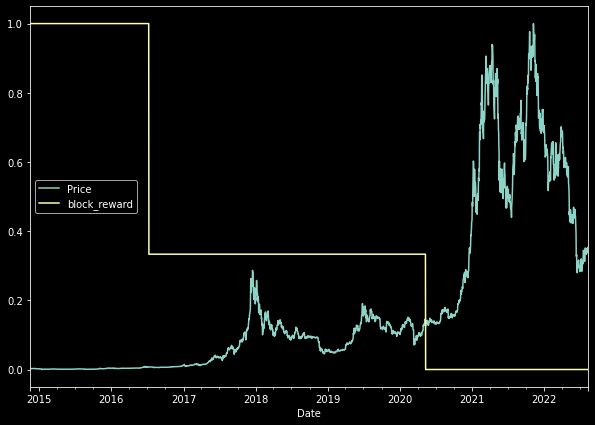

In [256]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

### Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.
<https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html>

In [258]:
# Setup dataset hyper-parameters
HORIZON = 1
WINDOW_SIZE = 7

In [261]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns 
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i + 1}"] = bitcoin_prices_windowed['Price'].shift(periods = i + 1)
    
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-11-15,376.132996,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-16,387.881989,25,376.132996,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-17,387.407990,25,387.881989,376.132996,NaN,NaN,NaN,NaN,NaN
2014-11-18,375.197998,25,387.407990,387.881989,376.132996,NaN,NaN,NaN,NaN
2014-11-19,380.554993,25,375.197998,387.407990,387.881989,376.132996,NaN,NaN,NaN
2014-11-20,357.839996,25,380.554993,375.197998,387.407990,387.881989,376.132996,NaN,NaN
2014-11-21,350.847992,25,357.839996,380.554993,375.197998,387.407990,387.881989,376.132996,NaN
2014-11-22,352.920013,25,350.847992,357.839996,380.554993,375.197998,387.407990,387.881989,376.132996
2014-11-23,367.572998,25,352.920013,350.847992,357.839996,380.554993,375.197998,387.407990,387.881989


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]

In [264]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price" , axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-22,25.0,350.847992,357.839996,380.554993,375.197998,387.407990,387.881989,376.132996
2014-11-23,25.0,352.920013,350.847992,357.839996,380.554993,375.197998,387.407990,387.881989
2014-11-24,25.0,367.572998,352.920013,350.847992,357.839996,380.554993,375.197998,387.407990
2014-11-25,25.0,376.901001,367.572998,352.920013,350.847992,357.839996,380.554993,375.197998
2014-11-26,25.0,375.347992,376.901001,367.572998,352.920013,350.847992,357.839996,380.554993


In [265]:
# Make train and test sets using indexing 
split_size = int(len(X) * 0.8)
X_train , y_train = X[:split_size] , y[:split_size]
X_test , y_test = X[split_size:] , y[split_size:]
len(X_train) , len(y_train) , len(X_test) , len(y_test)

(2256, 2256, 565, 565)

### Model 6: Dense (multivariate time series)

In [266]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128 , activation = 'relu'),
    layers.Dense(128 , activation = 'relu'),
    layers.Dense(HORIZON)
], name = 'model_6_dense_multivariate')

# Compile model
model_6.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(X_train , y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 1,
            validation_data = (X_test , y_test),
            callbacks = [create_model_checkpoint(model_name = model_6.name)])


Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1269.7056INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 72s 2s/step - loss: 1162.7773 - val_loss: 4903.2910
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 399.5745INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 37s 2s/step - loss: 390.1625 - val_loss: 1829.6903
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 247.0187INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 21s 1s/step - loss: 247.0187 - val_loss: 1625.8544
Epoch 4/100
 9/18 [==============>...............] - ETA: 0s - loss: 214.6748INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 20s 1s/step - loss: 212.0242 - val_loss: 1520.4902
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 196.9857INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 16s 951ms/step - loss: 202.1801 - val_loss: 1475.5098
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 211.7850 - val_loss: 1706.6803
Epoch 7/100
 9/18 [==============>...............] - ETA: 0s - loss: 208.5103INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 22s 1s/step - loss: 208.9238 - val_loss: 1393.3033
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 186.6365 - val_loss: 1412.1907
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 183.8202INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 19s 1s/step - loss: 183.8202 - val_loss: 1345.0358
Epoch 10/100
18/18 [==============================] - 0s 18ms/step - loss: 195.9453 - val_loss: 1481.7604
Epoch 11/100
18/18 [==============================] - 0s 11ms/step - loss: 194.7069 - val_loss: 1454.8157
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 175.1831INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 12s 694ms/step - loss: 177.7253 - val_loss: 1303.5276
Epoch 13/100
17/18 [===========================>..] - ETA: 0s - loss: 171.6527INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 12s 729ms/step - loss: 173.3329 - val_loss: 1295.4390
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 177.2219INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 11s 651ms/step - loss: 173.7947 - val_loss: 1282.2368
Epoch 15/100
18/18 [==============================] - 0s 8ms/step - loss: 170.9680 - val_loss: 1438.3623
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 134.3370INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 10s 593ms/step - loss: 169.5994 - val_loss: 1259.0676
Epoch 17/100
18/18 [==============================] - 0s 9ms/step - loss: 178.4662 - val_loss: 1311.8938
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 174.9737INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 8s 498ms/step - loss: 178.8294 - val_loss: 1234.4349
Epoch 19/100
15/18 [========================>.....] - ETA: 0s - loss: 189.4155INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 12s 730ms/step - loss: 190.4013 - val_loss: 1232.2332
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 166.1279 - val_loss: 1274.7350
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 177.1873 - val_loss: 1392.3273
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 193.0586 - val_loss: 1239.6737
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 162.6539 - val_loss: 1277.2140
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 181.0603 - val_loss: 1240.3494
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 176.8154 - val_loss: 1369.4956
Epoch 26/100
18/18 [==============================] - 0s 7ms/step - loss: 180.4804 - val_loss: 1531.1869
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 189.3894 - val_loss: 1624.5242
Epoch 28/100
18/18 [==============================] - 0s 9ms/step

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 9s 541ms/step - loss: 163.0870 - val_loss: 1223.5952
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 164.8420 - val_loss: 1367.7356
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 195.1440 - val_loss: 1451.6066
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 164.6927 - val_loss: 1232.0156
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 162.6733 - val_loss: 1265.0779
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 175.2229 - val_loss: 1239.6565
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 168.9732 - val_loss: 1459.3225
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 174.2504 - val_loss: 1285.3181
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 169.2798 - val_loss: 1262.6803
Epoch 38/100
18/18 [==============================] - 0s 5ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 5s 283ms/step - loss: 172.5417 - val_loss: 1217.7048
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 162.6695 - val_loss: 1288.7881
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 163.5319INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 4s 255ms/step - loss: 163.5319 - val_loss: 1208.5410
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 171.3168 - val_loss: 1377.5513
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 166.2846 - val_loss: 1210.6869
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 160.5565 - val_loss: 1263.3402
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 163.5265 - val_loss: 1212.0396
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 178.0616 - val_loss: 1394.8286
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 164.1452 - val_loss: 1333.2322
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 164.0070 - val_loss: 1292.3342
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 168.1942 - val_loss: 1255.1222
Epoch 51/100
18/18 [==============================] - 0s 5ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 4s 256ms/step - loss: 162.3343 - val_loss: 1201.9966
Epoch 62/100
18/18 [==============================] - 0s 8ms/step - loss: 158.6629 - val_loss: 1208.2644
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 163.6068 - val_loss: 1227.9221
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 163.2691 - val_loss: 1233.4038
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 163.8556 - val_loss: 1238.6564
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 161.8244 - val_loss: 1223.9393
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 168.2490 - val_loss: 1354.2600
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 169.7697 - val_loss: 1599.2955
Epoch 69/100
 1/18 [>.............................] - ETA: 0s - loss: 224.5121INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 7s 437ms/step - loss: 183.7723 - val_loss: 1199.1196
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 164.3851 - val_loss: 1358.1271
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 167.1069 - val_loss: 1307.9594
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 164.6079 - val_loss: 1199.9692
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 161.2413 - val_loss: 1216.9155
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 159.8090 - val_loss: 1731.9348
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 180.1179 - val_loss: 1290.9110
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 174.5739 - val_loss: 1240.6140
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 161.4161 - val_loss: 1200.3202
Epoch 78/100
18/18 [==============================] - 0s 5ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 6s 331ms/step - loss: 157.0395 - val_loss: 1199.0024
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 158.3048 - val_loss: 1201.9967
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 175.1339 - val_loss: 1295.9897
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 162.0845 - val_loss: 1239.2324
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 160.9695 - val_loss: 1268.6328
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 156.1775 - val_loss: 1206.8936
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 160.1927 - val_loss: 1199.0443
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 173.9576 - val_loss: 1399.6365
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 179.9847 - val_loss: 1318.0258
Epoch 91/100
18/18 [==============================] - 0s 5ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 5s 315ms/step - loss: 160.0264 - val_loss: 1196.4725
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 158.8370 - val_loss: 1211.7504


In [267]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test , y_test)

18/18 [==============================] - 1s 6ms/step - loss: 1196.4725


1196.4725341796875

In [268]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32167.291, 32210.074, 32456.615, 30471.846, 33178.113, 34334.91 ,
       34267.285, 33118.08 , 33644.74 , 35490.348], dtype=float32)>

In [270]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_6_preds)
model_6_results

{'mae': 1196.4724,
 'mse': 2765653.8,
 'rmse': 1663.0255,
 'mape': 2.8541517,
 'mase': 1.0049665}

### Model 7: N-BEATS algorithm

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: 
<a href = "https://arxiv.org/pdf/1905.10437.pdf">N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm does.</a>

* This will allow us to practice replicating a paper with TensorFlow code
* We will se how to use TensorFlow layer subclassing (to make our custom layers)
* Get experience using the Functional API to create a custom architecture.
* Potentially get state of the art results on our problem.



### Building and testing the N-BEATS block layer
Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.
To create custom layers and models in TensorFow we can use subclassing:
<https://www.tensorflow.org/guide/keras/custom_layers_and_models>

The `Layer` class: the combination of state (weights) and some computation

One of the central abstraction in Keras is the `Layer` class. A layer encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs (a "call", the layer's forward pass).

In [309]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

### Let's test our NBeatsBlock class.
To do we'll make some dummy inputs and outputs

In [310]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [311]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6]])>

In [312]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.20229004  0.45044464  0.27155775 -0.5771345  -0.5379472  -0.20395333]
Forecast: 0.6362250447273254


### Preparing data for the N-BEATS algorithm using `tf.data`
<https://www.tensorflow.org/guide/data_performance> 

In [313]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [314]:
# Create N-Beats data inputs (N-Beats works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2014-11-15,376.132996
2014-11-16,387.881989
2014-11-17,387.407990
2014-11-18,375.197998
2014-11-19,380.554993


In [315]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-11-22,352.920013,350.847992,357.839996,380.554993,375.197998,387.407990,387.881989,376.132996
2014-11-23,367.572998,352.920013,350.847992,357.839996,380.554993,375.197998,387.407990,387.881989
2014-11-24,376.901001,367.572998,352.920013,350.847992,357.839996,380.554993,375.197998,387.407990
2014-11-25,375.347992,376.901001,367.572998,352.920013,350.847992,357.839996,380.554993,375.197998
2014-11-26,368.369995,375.347992,376.901001,367.572998,352.920013,350.847992,357.839996,380.554993


In [316]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2256, 2256, 565, 565)

In [317]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm
The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18:
<https://arxiv.org/pdf/1905.10437.pdf>

In [318]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: <https://en.wikipedia.org/wiki/Residual_neural_network>

And here: <https://paperswithcode.com/method/resnet>

In [319]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks).
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecast for the model with the layer created in (1).
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create block which return backcasts and block-level forecasts.
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper.
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
    * Early stopping - because the model will be training for so long, we'll stop it early if it stops improving
    * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [320]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 145: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 245: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Wall time: 1h 4min 3s


In [321]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 19s 19s/step - loss: 1258.5211 - mae: 1258.5211 - mse: 2964440.0000


[1258.5211181640625, 1258.5211181640625, 2964440.0]

In [322]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7 , test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32110.588, 31690.49 , 31955.922, 31070.604, 32569.668, 33540.21 ,
       34099.6  , 33360.63 , 33322.51 , 34883.02 ], dtype=float32)>

In [323]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 1258.5211,
 'mse': 2964440.0,
 'rmse': 1721.7549,
 'mape': 3.0133648,
 'mase': 1.0570837}

### Plotting the N-BEATS architecture we've created

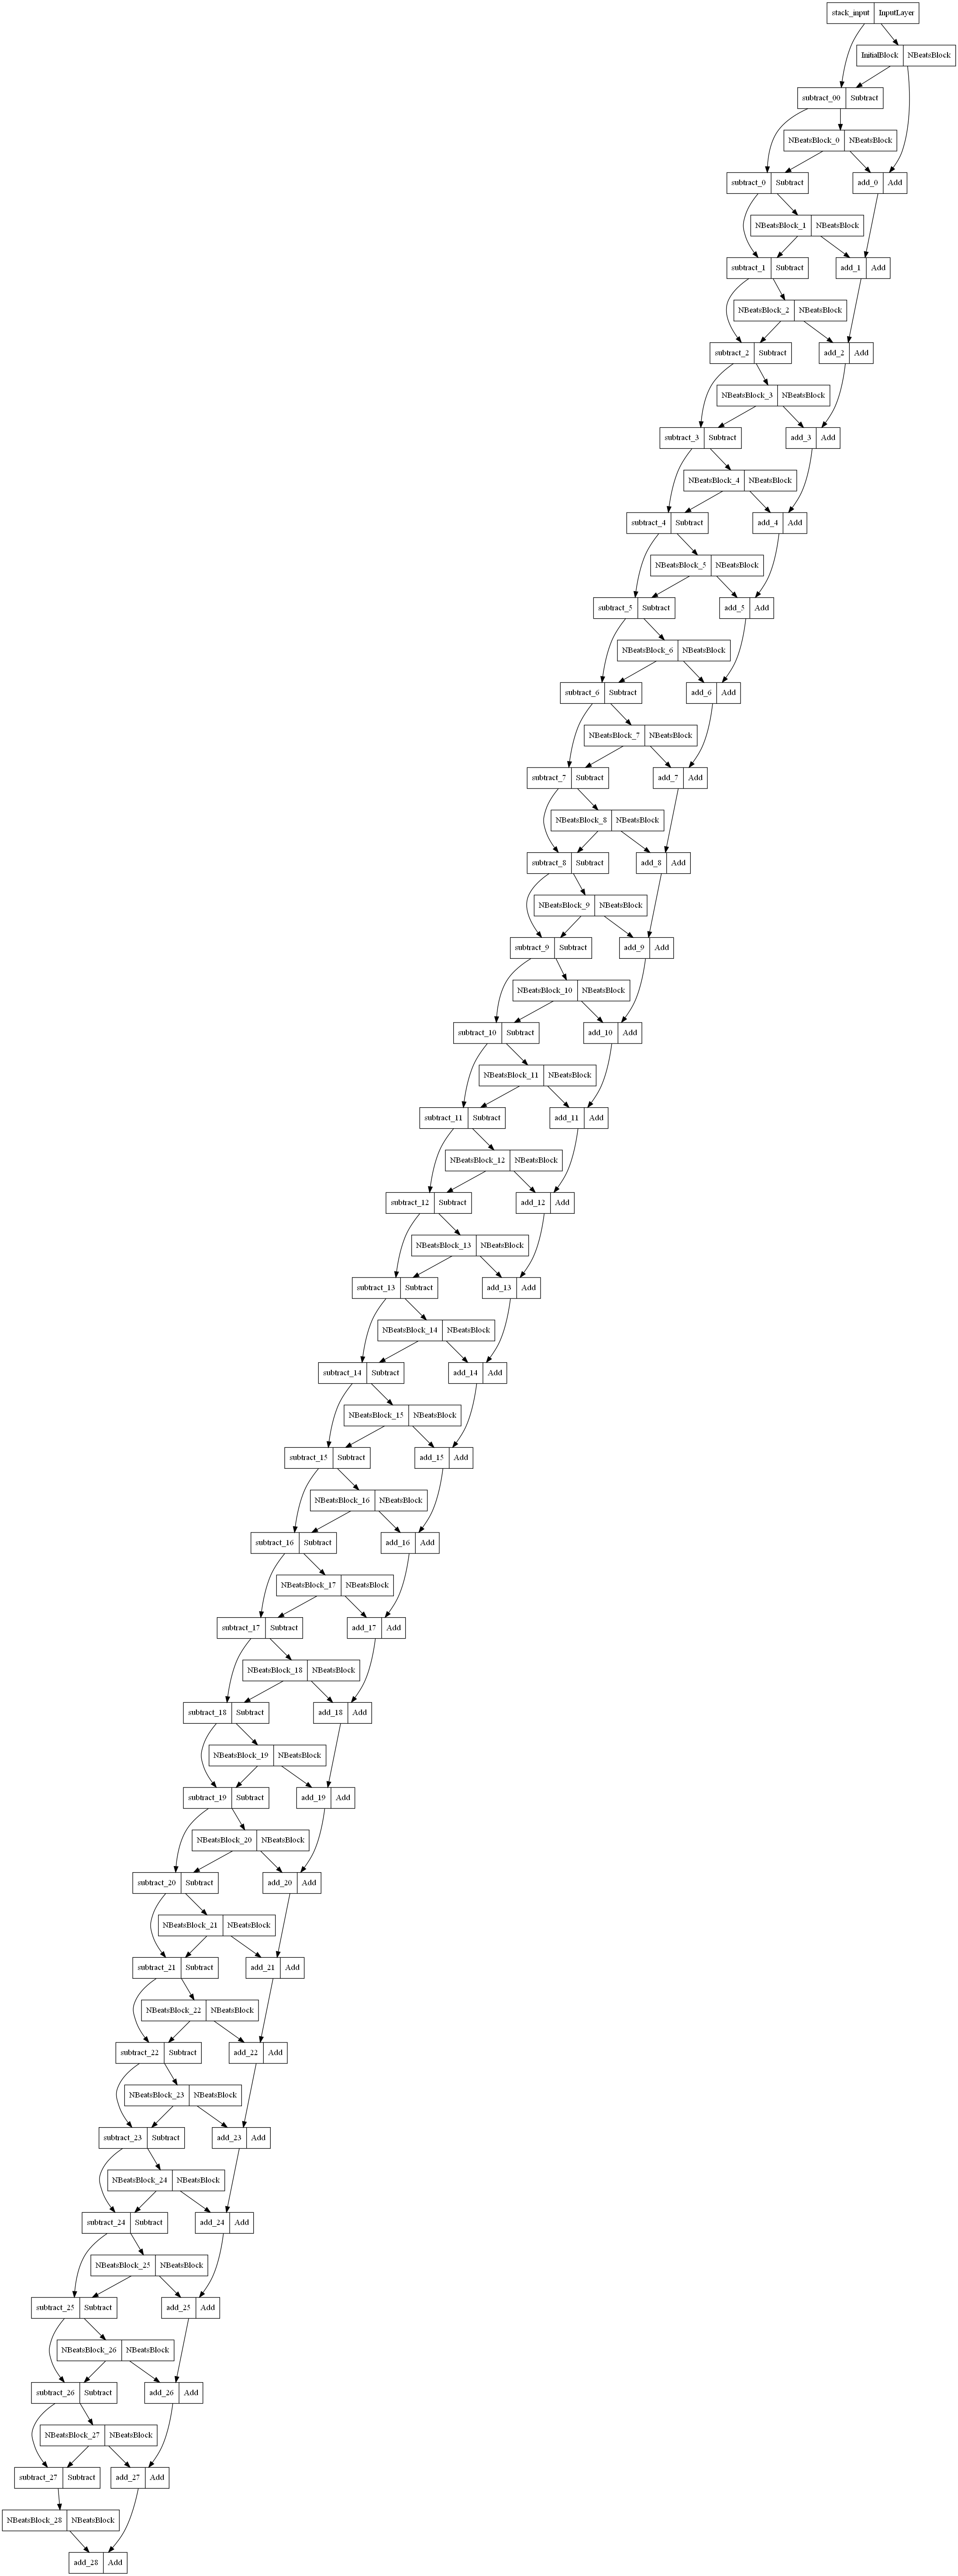

In [324]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [325]:
def get_ensemble_models(horizon = HORIZON,
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fns = ['mae' , 'mse' , 'mape']):
    '''
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
    For example, if num_iter = 10, a list of 30 trained models will be returned:
    10 * len(['mae' , 'mse' , 'mape']).
    '''
    # Make empty list for trained ensemble models
    ensemble_models = []
    
    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")
            
            # Construct a simple model (similar to model_1)
            model = tf.keras.Sequential([
                # Initialize dense layers with normal distribution for estimating prediction intervals later on
                layers.Dense(128, kernel_initializer = 'he_normal' , activation = 'relu'),
                layers.Dense(128, kernel_initializer = 'he_normal' , activation = 'relu'),
                layers.Dense(HORIZON)
            ])
            
            # Compile simple model with current loss function
            model.compile(loss = loss_function,
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = ['mae' , 'mse'])
            
            # Fit the current model
            model.fit(train_data,
                      epochs = num_epochs,
                      verbose = 0,
                      validation_data =  test_data,
                      # Add callbacks to prevent training from going/stalling for too long
                      callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                                    patience = 200,
                                                                    restore_best_weights = True),
                                   tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                                        patience = 100,
                                                                        verbose = 1)])
            
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)
        
    return ensemble_models

In [326]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 584: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 798: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 898: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 330: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 430: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 225: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 334: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 688: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 340: ReduceLROnPl

In [327]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models , data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [330]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models = ensemble_models,
                                     data = test_dataset)
ensemble_preds

<tf.Tensor: shape=(15, 565), dtype=float32, numpy=
array([[32440.033, 32448.564, 31566.016, ..., 23272.338, 24096.57 ,
        23965.857],
       [31855.916, 31371.197, 33188.23 , ..., 23226.592, 23939.186,
        23948.955],
       [32421.936, 32166.885, 32808.43 , ..., 23248.047, 23971.865,
        24031.611],
       ...,
       [32016.01 , 32202.986, 31391.873, ..., 23343.455, 23895.898,
        24114.06 ],
       [34120.207, 31889.967, 31178.012, ..., 23016.682, 24621.105,
        23558.781],
       [32125.207, 32265.09 , 32223.002, ..., 23192.963, 23964.088,
        23941.496]], dtype=float32)>

Our ensemble preds come out in multiple dimensions but to combine into `point predictions` we can leverage the mean of all of the predictions or the median-<https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/>

In [334]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 1199.6989,
 'mse': 2802769.8,
 'rmse': 1674.1475,
 'mape': 2.865028,
 'mase': 1.0076765}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldn't it be helpful of we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models).
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observation fall within 1.96 standard deviation of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1).

> <https://eng.uber.com/neural-networks-uncertainty-estimation/>

In [338]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

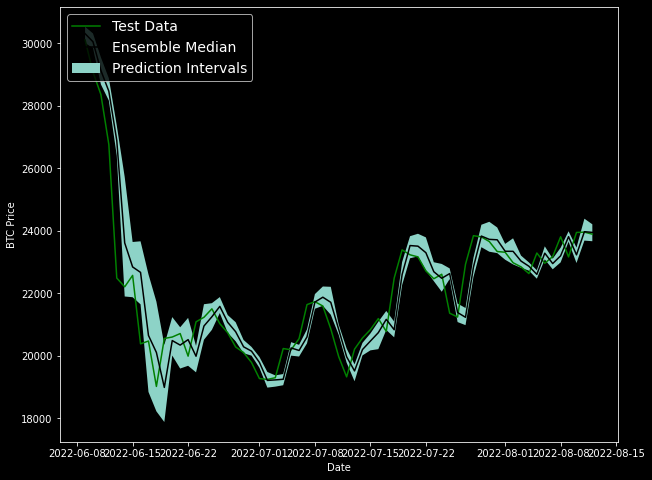

In [339]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis = 0)

# Plot the median of our ensemble preds along with the prediction
offset = 500
plt.figure(figsize = (10 , 8))
plt.plot(X_test.index[offset:] , y_test[offset:] , "g" , label = 'Test Data')
plt.plot(X_test.index[offset:] , ensemble_median[offset:] , "k-" , label = "Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label = 'Prediction Intervals')
plt.legend(loc = 'upper left' , fontsize = 14)

So far all of our models prediction have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

Aside: two types of uncertainty (coconut and subway)
Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a point prediction, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a prediction interval or uncertainty estimate can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

What can my model know? (with perfect data, what's possible to learn?)
What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning you should be aware of:

* Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).

* Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.
The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help

Aside: two types of uncertainty (coconut and subway)
Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a point prediction, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a prediction interval or uncertainty estimate can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

What can my model know? (with perfect data, what's possible to learn?)
What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning you should be aware of:

Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).
Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.
The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help.

Uncertainty in dating
Let's say you're going on a First Date Feedback Radio Show to help improve your dating skills.

Where you go on a blind first date with a girl (feel free to replace girl with your own preference) and the radio hosts record the date and then playback snippets of where you could've improved.

And now let's add a twist.

Last week your friend went on the same show. They told you about the girl they met and how the conversation went.

Because you're now a machine learning engineer, you decide to build a machine learning model to help you with first date conversations.

What levels of uncertainty do we have here?

From an aleatory uncertainty (data) point of view, no matter how many conversations of first dates you collect, the conversation you end up having will likely be different to the rest (the best conversations have no subject and appear random).

From an epistemic uncertainty (model) point of view, if the date is truly blind and both parties don't know who they're seeing until they meet in person, the epistemic uncertainty would be high. Because now you have no idea who the person you're going to meet is nor what you might talk about.

However, the level of epistemic uncertainty would be reduced if your friend told about the girl they went on a date with last week on the show and it turns out you're going on a date with the same girl.

But even though you know a little bit about the girl, your aleatory uncertainty (or subway uncertainty) is still high because you're not sure where the conversation will go.

If you're wondering where above scenario came from, it happened to me this morning. Good timing right?

### Learning more on uncertainty
The field of quantifying uncertainty estimation in machine learning is a growing area of research.

If you'd like to learn more I'd recommend the following.

> 📖 Resources: Places to learn more about uncertainty in machine learning/forecasting:

* <a href = "https://youtu.be/toTcf7tZK8c"> MIT 6.S191: Evidential Deep Learning and Uncertainty</a>
* <a href = "https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty">Uncertainty quantification on Wikipedia</a>
* <a href = "https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc">Why you should care about the Nate Silver vs. Nassim Taleb Twitter war</a> by Isaac Faber - a great insight into the role of uncertainty in the example of election prediction.
* <a href = "https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387">3 facts about time series forecasting that surprise experienced machine learning practitioners</a> by Skander Hannachi - fantastic outline of some of the main mistakes people make when building forecasting models, especially forgetting about uncertainty estimates.
* <a href = "https://eng.uber.com/neural-networks-uncertainty-estimation/">Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber</a>  - a discussion on techniques Uber used to engineer uncertainty estimates into their time sereis neural networks.



### Model 9: Train a model on the full historical data to make predictions into future

In [342]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [343]:
len(X_all) , len(y_all)

(2821, 2821)

In [345]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine feature & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all , labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # Taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [348]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name = 'model_9_future_model')

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=1) 

Epoch 1/100
3/3 [==============================] - 28s 281ms/step - loss: 8339.3613
Epoch 2/100
3/3 [==============================] - 0s 118ms/step - loss: 4445.4819
Epoch 3/100
3/3 [==============================] - 1s 159ms/step - loss: 865.0416
Epoch 4/100
3/3 [==============================] - 0s 89ms/step - loss: 2757.8367
Epoch 5/100
3/3 [==============================] - 0s 36ms/step - loss: 2762.6516
Epoch 6/100
3/3 [==============================] - 0s 158ms/step - loss: 1251.1412
Epoch 7/100
3/3 [==============================] - 0s 84ms/step - loss: 1054.6453
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 1528.8909
Epoch 9/100
3/3 [==============================] - 0s 54ms/step - loss: 987.0306
Epoch 10/100
3/3 [==============================] - 0s 32ms/step - loss: 733.5434
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 976.8767
Epoch 12/100
3/3 [==============================] - 0s 69ms/step - loss: 666.8838
Epoch 13/100


### Make predictions into future

In [396]:
# How many timestep to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. Take as input:
    * A list of values (Bitcoin historical data)
    * A trained model (such as `model_9`)
    * A window into the future to predict (our  `INTO_FUTURE variable`)
    * The window size a model was trained (`WINDOW_SIZE`) - the model can only  predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` which update to remove the first value and append the latest prediction

In [397]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [414]:
np.append(X_all , )

numpy.ndarray

In [398]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [22961.27929688 23175.890625   23809.48632812 23164.31835938
 23947.64257812 23957.52929688 23892.18945312] -> Prediction: 23201.56640625

Predicting on: 
 [23175.890625   23809.48632812 23164.31835938 23947.64257812
 23957.52929688 23892.18945312 23201.56640625] -> Prediction: 23562.1953125

Predicting on: 
 [23809.48632812 23164.31835938 23947.64257812 23957.52929688
 23892.18945312 23201.56640625 23562.1953125 ] -> Prediction: 23803.4453125

Predicting on: 
 [23164.31835938 23947.64257812 23957.52929688 23892.18945312
 23201.56640625 23562.1953125  23803.4453125 ] -> Prediction: 23679.6484375

Predicting on: 
 [23947.64257812 23957.52929688 23892.18945312 23201.56640625
 23562.1953125  23803.4453125  23679.6484375 ] -> Prediction: 24079.55859375

Predicting on: 
 [23957.52929688 23892.18945312 23201.56640625 23562.1953125
 23803.4453125  23679.6484375  24079.55859375] -> Prediction: 23968.40234375

Predicting on: 
 [23892.18945312 23201.56640625 23562.1953125  23803

### Plot future forecasts

In [399]:
def get_future_dates (start_date , into_future , offset = 1):
    '''
    Returns array of datetime values ranging from start_date to start_date + into_future
    '''
    start_date = start_date + np.timedelta64(offset , 'D') # specify start date, "D" stands of day
    end_date = start_date + np.timedelta64(into_future , "D") # specify end date
    return np.arange(start_date , end_date , dtype = "datetime64[D]") # return a date range between start and end date

In [400]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2022-08-12 00:00:00')

In [401]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date = last_timestep,
                                   into_future = INTO_FUTURE)
next_time_steps

array(['2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16',
       '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20',
       '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24',
       '2022-08-25', '2022-08-26'], dtype='datetime64[D]')

In [402]:
future_forecast

[23201.566,
 23562.195,
 23803.445,
 23679.648,
 24079.559,
 23968.402,
 23799.54,
 23508.531,
 23840.941,
 23966.396,
 23999.482,
 24142.479,
 23999.172,
 23869.832]

In [403]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0 , last_timestep)
future_forecast = np.insert(future_forecast, 0 , bitcoin_prices['Price'][-1])
next_time_steps , future_forecast

(array(['2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15',
        '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
        '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23',
        '2022-08-24', '2022-08-25', '2022-08-26'], dtype='datetime64[D]'),
 array([23892.19 , 23201.566, 23562.195, 23803.445, 23679.648, 24079.559,
        23968.402, 23799.54 , 23508.531, 23840.941, 23966.396, 23999.482,
        24142.479, 23999.172, 23869.832], dtype=float32))

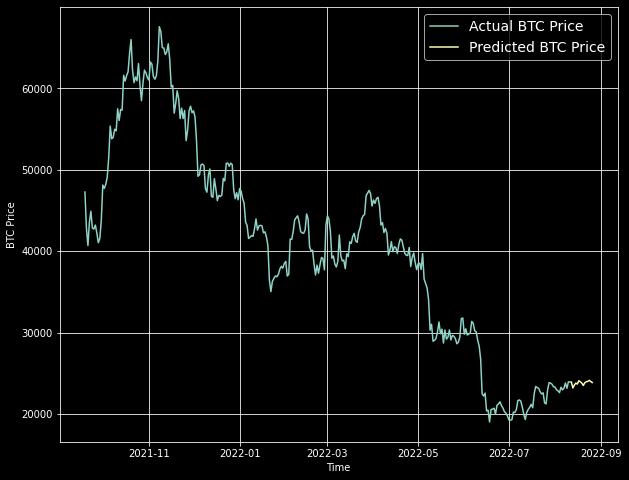

In [409]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize = (10 , 8))
plot_time_series(bitcoin_prices.index , bitcoin_prices, start = 2500 , format = '-' , label = "Actual BTC Price")
plot_time_series(next_time_steps , future_forecast , format = '-' , label = 'Predicted BTC Price')

### Model 10: Why forecasting is BS (the turkey problem)

📖 Resource: 
> <a href= "https://youtu.be/hRwimmE2wEk">Explaining both the XIV trade and why forecasting is BS</a> by Nassim Taleb

> <a href = "https://en.wikipedia.org/wiki/The_Black_Swan:_The_Impact_of_the_Highly_Improbable">The Black Swan</a> by Nassim Taleb (epsecially Chapter 4 which outlines and discusses the turkey problem)

> Note: A very unlikely and unpredictable event such as the price of Bitcoin falling 100x in a single day (note: the adjective "unlikely" is based on the historical price changes of Bitcoin) is also referred to a Black Swan event. A Black Swan event is an unknown, you have no way of predicting whether or not it will happen but these kind of events often have a large impact.


In [420]:
# Let's introduce a Turkey problem to our BTC data 
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [421]:
btc_price_turkey[-10:]

array([22846.5078125 , 22630.95703125, 23289.31445312, 22961.27929688,
       23175.890625  , 23809.48632812, 23164.31835938, 23947.64257812,
       23957.52929688,   238.92189453])

In [422]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2022-08-03T00:00:00.000000000', '2022-08-04T00:00:00.000000000',
       '2022-08-05T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-07T00:00:00.000000000', '2022-08-08T00:00:00.000000000',
       '2022-08-09T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2022-08-11T00:00:00.000000000', '2022-08-12T00:00:00.000000000'],
      dtype='datetime64[ns]')

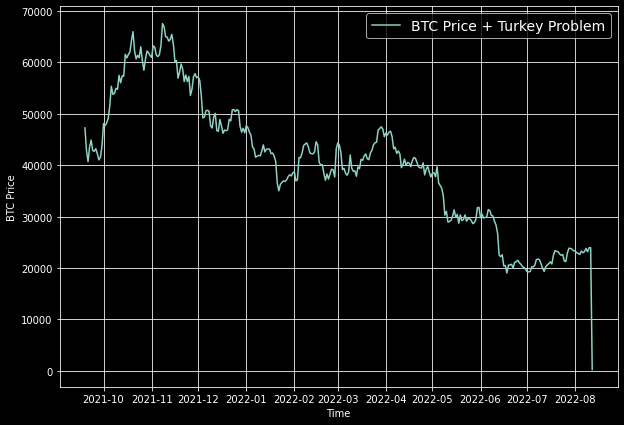

In [423]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [425]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2256, 565, 2256, 565)

### Building a turkey model (model to predict on turkey data)

In [426]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = 'model_10_turkey_model'
turkey_model.compile(loss = 'mae',
                     optimizer = tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs = 100,
                 verbose = 1,
                 batch_size = 128,
                 validation_data = [X_test , y_test],
                 callbacks = [create_model_checkpoint(turkey_model.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1489.3662INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 76s 3s/step - loss: 1472.0568 - val_loss: 6492.3350
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 439.1865INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 46s 3s/step - loss: 424.7645 - val_loss: 2636.0349
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 318.8879INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 39s 2s/step - loss: 307.9461 - val_loss: 2209.6624
Epoch 4/100
18/18 [==============================] - 1s 37ms/step - loss: 284.2617 - val_loss: 2382.4585
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 284.9691INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 72s 4s/step - loss: 284.9691 - val_loss: 2016.7007
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 268.2436INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 45s 3s/step - loss: 268.2436 - val_loss: 1972.8737
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 252.3517INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 35s 2s/step - loss: 259.9073 - val_loss: 1914.7443
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 250.4494INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 52s 3s/step - loss: 250.4494 - val_loss: 1880.2135
Epoch 9/100
18/18 [==============================] - ETA: 0s - loss: 249.3173INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 21s 1s/step - loss: 249.3173 - val_loss: 1862.7577
Epoch 10/100
10/18 [===============>..............] - ETA: 0s - loss: 243.0175INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 22s 1s/step - loss: 244.9968 - val_loss: 1790.1156
Epoch 11/100
 9/18 [==============>...............] - ETA: 0s - loss: 252.3142INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 14s 827ms/step - loss: 238.8133 - val_loss: 1736.6554
Epoch 12/100
13/18 [====================>.........] - ETA: 0s - loss: 232.3513INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 11s 670ms/step - loss: 228.5984 - val_loss: 1696.6022
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 222.4218INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 15s 867ms/step - loss: 222.4218 - val_loss: 1670.6981
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 225.9490INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 9s 505ms/step - loss: 222.0550 - val_loss: 1660.3076
Epoch 15/100
18/18 [==============================] - 0s 15ms/step - loss: 220.3744 - val_loss: 1764.7770
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 169.6953INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 8s 456ms/step - loss: 213.7259 - val_loss: 1637.6139
Epoch 17/100
18/18 [==============================] - 0s 18ms/step - loss: 223.2358 - val_loss: 1686.2925
Epoch 18/100
11/18 [=================>............] - ETA: 0s - loss: 197.2302INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 21s 1s/step - loss: 210.8681 - val_loss: 1562.5604
Epoch 19/100
18/18 [==============================] - 0s 23ms/step - loss: 204.9389 - val_loss: 1684.4751
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 202.4034INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 10s 597ms/step - loss: 203.2430 - val_loss: 1545.0889
Epoch 21/100
18/18 [==============================] - 0s 22ms/step - loss: 200.7729 - val_loss: 1554.3214
Epoch 22/100
18/18 [==============================] - 0s 27ms/step - loss: 195.7007 - val_loss: 1556.1914
Epoch 23/100
18/18 [==============================] - 0s 19ms/step - loss: 200.7238 - val_loss: 1625.7648
Epoch 24/100
 2/18 [==>...........................] - ETA: 4s - loss: 179.5519INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 10s 588ms/step - loss: 195.7307 - val_loss: 1470.3960
Epoch 25/100
18/18 [==============================] - 0s 16ms/step - loss: 193.7448 - val_loss: 1500.4463
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 197.6264INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 11s 667ms/step - loss: 197.9326 - val_loss: 1450.0150
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 196.3170INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 10s 601ms/step - loss: 191.4390 - val_loss: 1448.0643
Epoch 28/100
18/18 [==============================] - 1s 35ms/step - loss: 194.9708 - val_loss: 1548.1985
Epoch 29/100
14/18 [======================>.......] - ETA: 0s - loss: 185.4672INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 16s 917ms/step - loss: 185.9516 - val_loss: 1415.0505
Epoch 30/100
10/18 [===============>..............] - ETA: 0s - loss: 183.3906INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 8s 461ms/step - loss: 184.3740 - val_loss: 1409.5710
Epoch 31/100
18/18 [==============================] - 0s 13ms/step - loss: 190.9108 - val_loss: 1626.5480
Epoch 32/100
18/18 [==============================] - 0s 17ms/step - loss: 187.0878 - val_loss: 1436.3998
Epoch 33/100
18/18 [==============================] - 0s 14ms/step - loss: 188.9745 - val_loss: 1413.5808
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 164.5931INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 8s 454ms/step - loss: 182.6625 - val_loss: 1404.4056
Epoch 35/100
 8/18 [============>.................] - ETA: 0s - loss: 182.4252INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 9s 506ms/step - loss: 180.7382 - val_loss: 1368.8895
Epoch 36/100
18/18 [==============================] - 0s 10ms/step - loss: 184.5788 - val_loss: 1372.5300
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 177.5893INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 8s 462ms/step - loss: 178.5651 - val_loss: 1366.8466
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 177.5783 - val_loss: 1391.3339
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 181.4981INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 10s 571ms/step - loss: 179.1151 - val_loss: 1347.0938
Epoch 40/100
13/18 [====================>.........] - ETA: 0s - loss: 175.5360INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 6s 364ms/step - loss: 174.7598 - val_loss: 1339.7981
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 172.2761 - val_loss: 1392.2012
Epoch 42/100
18/18 [==============================] - ETA: 0s - loss: 177.1910INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 9s 551ms/step - loss: 177.1910 - val_loss: 1328.2406
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 174.6010 - val_loss: 1335.4644
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 151.5655INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 14s 845ms/step - loss: 177.1177 - val_loss: 1318.1069
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 127.1048INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 5s 304ms/step - loss: 179.2062 - val_loss: 1313.6206
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 176.9786 - val_loss: 1318.8263
Epoch 47/100
18/18 [==============================] - 0s 11ms/step - loss: 169.5974 - val_loss: 1325.1429
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 170.3035 - val_loss: 1367.0402
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 172.2445 - val_loss: 1320.5570
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 147.1178INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 6s 342ms/step - loss: 168.6763 - val_loss: 1291.6074
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 174.3377 - val_loss: 1346.7346
Epoch 52/100
18/18 [==============================] - 0s 9ms/step - loss: 176.9750 - val_loss: 1311.7081
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 246.2939INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 5s 285ms/step - loss: 167.9008 - val_loss: 1283.1742
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 169.9875 - val_loss: 1286.6902
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 129.0964INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 7s 397ms/step - loss: 167.3919 - val_loss: 1275.6388
Epoch 56/100
18/18 [==============================] - 0s 9ms/step - loss: 175.5166 - val_loss: 1281.3429
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 165.3985 - val_loss: 1285.7946
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 165.6215 - val_loss: 1289.1731
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 169.1992 - val_loss: 1278.2430
Epoch 60/100
11/18 [=================>............] - ETA: 0s - loss: 172.1468INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 9s 545ms/step - loss: 172.0665 - val_loss: 1270.2002
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 165.9211 - val_loss: 1278.0330
Epoch 62/100
 2/18 [==>...........................] - ETA: 0s - loss: 115.5129INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 5s 308ms/step - loss: 167.2376 - val_loss: 1269.0905
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 178.4611 - val_loss: 1446.2252
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 189.9675INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 247ms/step - loss: 167.2527 - val_loss: 1254.6881
Epoch 65/100
18/18 [==============================] - 0s 4ms/step - loss: 163.2721 - val_loss: 1394.4697
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 209.0538INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 245ms/step - loss: 173.1416 - val_loss: 1254.5349
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 163.4715 - val_loss: 1362.5122
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 170.4710INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 6s 338ms/step - loss: 169.2141 - val_loss: 1252.8727
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 162.8459 - val_loss: 1290.2524
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 163.1868 - val_loss: 1252.9148
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 162.7921 - val_loss: 1278.2545
Epoch 72/100
18/18 [==============================] - 0s 4ms/step - loss: 178.8746 - val_loss: 1281.6359
Epoch 73/100
 1/18 [>.............................] - ETA: 0s - loss: 129.3586INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 240ms/step - loss: 161.9488 - val_loss: 1251.8170
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 165.3182 - val_loss: 1324.8232
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 167.7694 - val_loss: 1269.2930
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 196.6778INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 264ms/step - loss: 166.0563 - val_loss: 1241.4077
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 161.6461 - val_loss: 1241.7819
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 166.5400 - val_loss: 1306.6263
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 165.9544 - val_loss: 1374.6707
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 169.1760 - val_loss: 1278.7766
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 154.6767INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 244ms/step - loss: 165.8687 - val_loss: 1234.2626
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 162.1771 - val_loss: 1240.0907
Epoch 83/100
18/18 [==============================] - 0s 8ms/step - loss: 162.8681 - val_loss: 1262.4469
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 172.9112 - val_loss: 1431.4781
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 166.4800 - val_loss: 1260.7335
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 160.9868 - val_loss: 1235.9087
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 164.1932 - val_loss: 1236.2600
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 161.7922 - val_loss: 1239.2971
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 169.0182 - val_loss: 1273.6752
Epoch 90/100
18/18 [==============================] - 0s 6ms/step 

INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 218ms/step - loss: 161.4280 - val_loss: 1230.6556
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 162.6283 - val_loss: 1249.5770
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 170.9442 - val_loss: 1335.8115
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 163.7774 - val_loss: 1400.0476
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 166.4437 - val_loss: 1231.3583
Epoch 97/100
 1/18 [>.............................] - ETA: 0s - loss: 154.9910INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


18/18 [==============================] - 4s 219ms/step - loss: 161.0909 - val_loss: 1229.7122
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 160.9785 - val_loss: 1241.2603
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 160.4706 - val_loss: 1230.4409
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 161.5563 - val_loss: 1245.5123


In [427]:
# Evaluate model on test data
turkey_model.evaluate(X_test , y_test)

18/18 [==============================] - 0s 3ms/step - loss: 1245.5123


1245.5123291015625

In [428]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model")
turkey_model.evaluate(X_test , y_test)

18/18 [==============================] - 1s 2ms/step - loss: 1229.7119


1229.7119140625

In [429]:
# Make predictions with turkey model 
turkey_preds = make_preds(turkey_model , X_test)
turkey_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([32165.832, 32341.488, 32357.59 , 30788.193, 33034.78 , 34296.965,
       34270.49 , 33360.133, 33400.28 , 35407.42 ], dtype=float32)>

In [433]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true = y_test,
                                y_pred = turkey_preds)
turkey_results

{'mae': 13265.56,
 'mse': 271231580.0,
 'rmse': 15839.016,
 'mape': 66.7481,
 'mase': 10.763148}

In [434]:
model_1_results

{'mae': 1202.2908,
 'mse': 2808114.2,
 'rmse': 1675.7429,
 'mape': 2.865633,
 'mase': 1.0102842}

In [435]:
plt.figure(figsize = (10 , 8))
offset = 300
plot_time_series(timesteps = tur)

<function __main__.plot_time_series(timesteps, values, format='.', start=0, end=None, label=None)>

<Figure size 720x576 with 0 Axes>

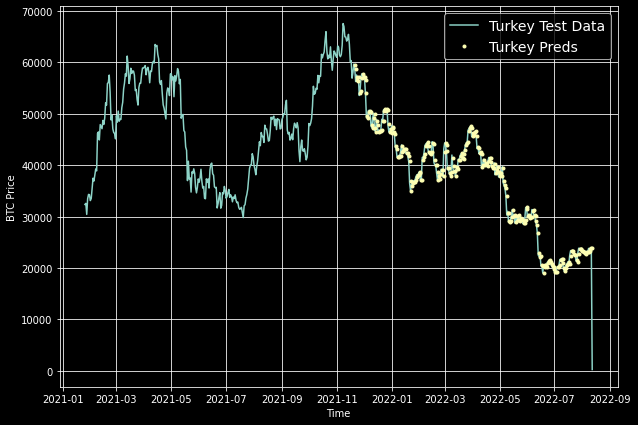

In [438]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values = btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data")
plot_time_series(timesteps = btc_timesteps_turkey[-len(X_test):],
                 values = turkey_preds,
                 label = "Turkey Preds",
                 start = offset)

### Compare Models

In [439]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,1188.588623,2.765042e+06,1662.841675,2.826824,0.998345
model_1_dense_w7_h1,1202.290771,2.808114e+06,1675.742920,2.865633,1.010284
model_2_dense_w30_h1,1291.439331,3.081774e+06,1755.498169,3.104415,1.111028
model_3_dense_w30_h7,2506.349854,1.133060e+07,2863.931396,6.011974,2.149517
model_4_CONV1D,1220.144287,2.836139e+06,1684.084106,2.901338,1.025287
model_5_LSTM,1232.876953,2.892306e+06,1700.678223,2.941029,1.035986
model_6_multivariate,1196.472412,2.765654e+06,1663.025513,2.854152,1.004966
model_8_NBEATs,1258.521118,2.964440e+06,1721.754883,3.013365,1.057084
model_9_ensemble,1199.698853,2.802770e+06,1674.147461,2.865028,1.007676
model_10_turkey,13265.559570,2.712316e+08,15839.015625,66.748100,10.763148


<AxesSubplot:>

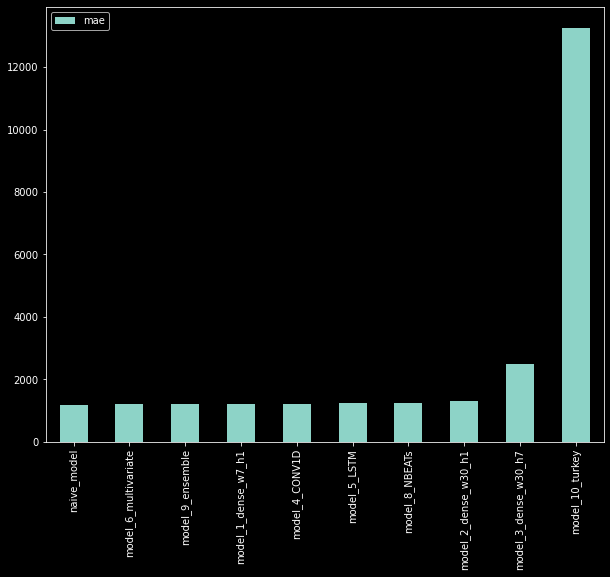

In [441]:
# Sort model results by MAE and plot them 
model_results[['mae']].sort_values(by = 'mae').plot(figsize = (10 ,  8) , kind = 'bar')